In [1]:
from IPython.core.interactiveshell import InteractiveShell
from google.colab import drive
drive.mount('/content/drive/')
!unzip "/content/drive/MyDrive/VQA_Dataset_draw.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Images/5391.png  
  inflating: /content/Images/5392.png  
  inflating: /content/Images/5393.png  
  inflating: /content/Images/5394.png  
  inflating: /content/Images/5395.png  
  inflating: /content/Images/5396.png  
  inflating: /content/Images/5397.png  
  inflating: /content/Images/5398.png  
  inflating: /content/Images/5399.png  
  inflating: /content/Images/54.png  
  inflating: /content/Images/540.png  
  inflating: /content/Images/5400.png  
  inflating: /content/Images/5401.png  
  inflating: /content/Images/5402.png  
  inflating: /content/Images/5403.png  
  inflating: /content/Images/5404.png  
  inflating: /content/Images/5405.png  
  inflating: /content/Images/5406.png  
  inflating: /content/Images/5407.png  
  inflating: /content/Images/5408.png  
  inflating: /content/Images/5409.png  
  inflating: /content/Images/541.png  
  inflating: /content/Images/5410.png  
  inflating: /content/Images/5411

In [2]:
import os
import tensorflow as tf
import numpy as np
import json
import pandas as pd
import pathlib
from tensorflow import keras as kr
import operator
import json
import pathlib
import functools
from datetime import datetime
from math import ceil
import sklearn as sk
import sklearn.model_selection
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import Tuple, List, Dict, Any, Callable, Union, Iterator, Iterable

In [3]:
SEED = 2014
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
# BATCH_SIZE = 50
# IMAGE_SIZE = (256,256)
# EPOCHS = 12
# EMBEDDING_SIZE = 64
# LSTM_UNITS = 256
# LR = 1e-1

BATCH_SIZE = 100
IMAGE_SIZE = (256,256)
EPOCHS = 12
EMBEDDING_SIZE = 64
LSTM_UNITS = 256
LR = 1e-3

In [5]:
PATH_DATA = '/content/'
PATH_TRAINING = PATH_DATA + "train_questions_annotations.json"
PATH_TEST = PATH_DATA + "test_questions.json"
PATH_IMAGE = PATH_DATA + "Images"
PATH_RESULT = PATH_DATA + "result.csv"

In [6]:
answer_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

In [7]:
import pickle
with open('ANSWER_LABELS.pickle', 'wb') as handle:
    pickle.dump(answer_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('ANSWER_LABELS.pickle', 'rb') as handle:
    answer_dict = pickle.load(handle)

### Data preparation

In [9]:
# with open(PATH_TRAINING) as file:
#     training_data = json.load(file)
# with open(PATH_TEST) as file:
#     test_data = json.load(file)

# for i in training_data:
#     training_data[i]["id"] = i
# for i in test_data:
#     test_data[i]["id"] = i
    
# training_data = list(training_data.values())
# test_data = list(test_data.values())

# def split_question(v):
#     v["question"] = v["question"].split(" ")
#     return v
# def add_eos(v):
#     v["question"].append("<eos>")
#     return v
# def parse_answer(v):
#     v["answer"] = LABELS_ANSWERS[v["answer"]]
#     return v
# def set_image_path(v):
#     v["image"] = PATH_IMAGE + '/'+ str(v['image_id'])+'.png'
#     return v
    

# training_data = map(split_question, training_data)
# test_data = map(split_question, test_data)

# training_data = map(add_eos, training_data)
# test_data = map(add_eos, test_data)

# training_data = map(parse_answer, training_data)

# training_data = map(set_image_path, training_data)
# test_data = map(set_image_path, test_data)

# training_data = list(training_data)
# test_data = list(test_data)

In [10]:
def load_file(path, train):
  f = open(path)
  j = json.load(f)
  for i in j:
    j[i]["id"] = i
  j = list(j.values())
  j = map(preprocess,j)
  if train :
      j = map(preprocess_ans, j)
  return list(j)

def preprocess(j):
  j["question"] = j["question"].split(" ")
  j["question"].append("<eos>")
  j["image"] = PATH_IMAGE + '/'+ str(j['image_id'])+'.png'
  return j

def preprocess_ans(j):
  j["answer"] = answer_dict[j["answer"]]
  return j

In [11]:
training_data = load_file(PATH_TRAINING, True)
test_data = load_file(PATH_TEST, False)

question_tokenizer = Tokenizer(filters='?!,."',num_words= 0)
question_tokenizer.fit_on_texts([*list(map(operator.itemgetter('question'), training_data)),*list(map(operator.itemgetter('question'), test_data))])
def convQuesToSeq(j):
    j["question"] = question_tokenizer.texts_to_sequences(j["question"])
    j["question"] = functools.reduce(operator.iconcat, j["question"], [])
    return j
    
training_data = list(map(convQuesToSeq, training_data))
test_data = list(map(convQuesToSeq, test_data))

In [12]:
vocab_size = len(question_tokenizer.index_word) + 1

In [13]:
def findMaxLen(j):
  ml = -1
  for k in j:
    ml = max(ml, len(k['question']))
  return ml

max_len_question = max(findMaxLen(training_data), findMaxLen(test_data))
print("maximum length of the question is :", max_len_question)

maximum length of the question is : 22


In [14]:
def padding(k):
    for j in k:
      j["question"] = pad_sequences([j["question"]], maxlen = max_len_question, padding='post').flatten()
    return list(k)

training_data = padding(training_data)
test_data = padding(test_data)

### Dataset

In [15]:
class CustomDataset(tf.keras.utils.Sequence):
    _seed = SEED

    def __init__(self,
                 data: List,
                 data_generator_options: Dict = None,
                 preprocessing_function: Callable[[np.array], np.array] = lambda x: x,
                 image_size: Tuple[int, int] = (256, 256),
                 data_per_batch: int = 1,
                 shuffle: bool = False,
                 is_test: bool = False
                ):
      
        self._data = data
        self._preprocessing_function = preprocessing_function
        self._data_per_batch = data_per_batch
        self._image_size = image_size
        self._shuffle = shuffle
        self._is_test = is_test
        
        self._transform_generator = self._get_transform_generator()
        if self._shuffle:
            np.random.shuffle(self._data)
        
        self._data_generator = None
        if data_generator_options is not None:
            self._data_generator = kr.preprocessing.image.ImageDataGenerator(**data_generator_options)
        
    def __len__(self):
        if self._data_per_batch == 0:
            return 1
        
        return ceil(len(self._data) / self._data_per_batch)

    def __getitem__(self, batch_index: int) -> Union[Tuple[np.array, np.array], Tuple[Tuple[np.array, np.array], np.array]]:
        batch_images=[]
        batch_questions=[]
        batch_answers=[]
        batch_indexes = range(len(self._data)) if self._data_per_batch == 0 else range(batch_index * self._data_per_batch,(1 + batch_index) * self._data_per_batch)
        
        for i in batch_indexes:
            if len(self._data) <= i:
                break
            image, question, answer = self._get_data(i)
            
            batch_images.append(image)
            batch_questions.append(question)
            
            if answer is not None:
                batch_answers.append(answer)
        
        if self._is_test:
            return tuple([np.array(batch_images), np.array(batch_questions)]), None
        
        return tuple([np.array(batch_images), np.array(batch_questions)]), np.array(batch_answers)
    
    def _get_data(self, index: int) -> Tuple[np.array, np.array, Union[np.array, None]]:
        data = self._data[index]
        image = kr.preprocessing.image.load_img(data["image"], grayscale=False, color_mode="rgb", target_size=IMAGE_SIZE, interpolation="nearest")
        image = kr.preprocessing.image.img_to_array(image)
        
        if self._data_generator is not None:
            transf_image = next(self._transform_generator)
            image = self._data_generator.apply_transform(image, transf_image)
            
        image = self._preprocessing_function(image)
        if self._is_test:
            return image, data["question"], None
        
        return image, data["question"], data["answer"]
    
    def on_epoch_end(self) -> None:
        if self._shuffle:
            np.random.shuffle(self._data)

    def _get_transform_generator(self):
        while True:
            yield self._data_generator.get_random_transform(self._image_size, seed=CustomDataset._seed)
            CustomDataset._seed += 1

In [16]:
training_data, validation_data = sk.model_selection.train_test_split(training_data, test_size= 0.2, random_state=SEED)
preprocessing_function = kr.applications.xception.preprocess_input
generator_options = dict(
                rotation_range=10,
                zoom_range=0.5,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.15,
                horizontal_flip=False,
                fill_mode="constant"
            )

training_ds = CustomDataset(
    training_data,
    data_generator_options=generator_options,
    preprocessing_function=preprocessing_function,
    image_size=IMAGE_SIZE,
    data_per_batch = BATCH_SIZE,
    shuffle=True
)
valid_ds = CustomDataset(
    validation_data,
    data_generator_options=generator_options,
    preprocessing_function=preprocessing_function,
    image_size=IMAGE_SIZE,
    data_per_batch = BATCH_SIZE,
    shuffle=True
)

test_ds = CustomDataset(
    test_data,
    preprocessing_function=preprocessing_function,
    image_size=IMAGE_SIZE,
    data_per_batch= BATCH_SIZE,
    is_test=True
)

print("{} data for training".format(len(training_data)))
print("{} data for validation".format(len(validation_data)))
print("{} data to test".format(len(test_data)))

47065 data for training
11767 data for validation
6372 data to test


### Model

In [17]:
# def get_callbacks(
#                   save_model: bool = True,
#                   checkpoints: bool = False,
#                   tensorboard: bool = True,
#                   early_stopping: bool = True
#                   ) -> List[kr.callbacks.Callback]:
#     callbacks = []
#     if save_model:
#         os.makedirs(PATH_EXPERIMENT + "model", exist_ok=True)
#         callbacks.append(kr.callbacks.ModelCheckpoint(str(PATH_EXPERIMENT + "model"), save_best_only=True, mode='min'))

#     if checkpoints:
#         # if they are requesed, checkpoints will be saved in a specific experiment subdirecotry
#         os.makedirs(PATH_EXPERIMENT + "checkpoints", exist_ok=True)

#         callbacks.append(kr.callbacks.ModelCheckpoint(
#             str(PATH_EXPERIMENT + "checkpoints" + "cp-{epoch:04d}.ckpt")
#         ))

#     if tensorboard:
#         # if they are required, tensorboard files will be generated
#         os.makedirs(PATH_EXPERIMENT + "tb_log", exist_ok=True)

#         callbacks.append(kr.callbacks.TensorBoard(
#             PATH_EXPERIMENT + "tb_log",
#             histogram_freq=1,
#             profile_batch=0
#         ))
#     if early_stopping:
#         callbacks.append(kr.callbacks.EarlyStopping(
#             patience=5,
#             restore_best_weights=True
#         ))

#     return callbacks

In [18]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
def createImageModel():
  input_image = kr.layers.Input(shape=(*IMAGE_SIZE, 3))
  image_model = kr.applications.Xception(weights="imagenet", include_top=False, input_tensor= input_image )
  image_model.trainable = False
  image_model = kr.layers.Dense(LSTM_UNITS)(image_model.output)
  return image_model, input_image

def createQuestionModel():
  input_question = kr.layers.Input(shape=(max_len_question))
  question_model = kr.layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=max_len_question, mask_zero=True)(input_question)
  question_model = tf.keras.layers.LSTM(units=LSTM_UNITS)(question_model)
  return question_model, input_question

image_model, image_input = createImageModel()
question_model, question_input = createQuestionModel()

83697664/83683744 [==============================] - 1s 0us/step


In [20]:
classificator_model = tf.keras.layers.Multiply()([image_model, question_model])

classificator_model = kr.layers.Flatten()(classificator_model)
classificator_model = kr.layers.Dense(128, activation=kr.activations.relu)(classificator_model)
classificator_model = kr.layers.Dropout(0.5)(classificator_model)
classificator_model = kr.layers.Dense(len(answer_dict), activation=kr.activations.softmax)(classificator_model)

model = kr.Model(inputs=[image_input, question_input], outputs=classificator_model)

model.inputs

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [21]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
metrics = [
    kr.metrics.SparseCategoricalAccuracy(name='accuracy')
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [22]:
vocab_size, max_len_question, len(answer_dict)

(6617, 22, 58)

In [23]:
train_hist = model.fit(
    training_ds,
    validation_data = valid_ds,
    epochs = EPOCHS,
    callbacks= [model_checkpoint_callback] 
)

Epoch 1/12
471/471 [==============================] - 1523s 3s/step - loss: 1.6167 - accuracy: 0.4504 - val_loss: 1.1553 - val_accuracy: 0.5472
Epoch 2/12
471/471 [==============================] - 1413s 3s/step - loss: 1.1597 - accuracy: 0.5527 - val_loss: 1.0363 - val_accuracy: 0.5766
Epoch 3/12
471/471 [==============================] - 1371s 3s/step - loss: 1.0483 - accuracy: 0.5825 - val_loss: 1.0191 - val_accuracy: 0.5900
Epoch 4/12
471/471 [==============================] - 1355s 3s/step - loss: 0.9933 - accuracy: 0.6012 - val_loss: 1.0231 - val_accuracy: 0.5897
Epoch 5/12
471/471 [==============================] - 1386s 3s/step - loss: 0.9390 - accuracy: 0.6177 - val_loss: 1.0321 - val_accuracy: 0.5914
Epoch 6/12
471/471 [==============================] - 1417s 3s/step - loss: 0.9043 - accuracy: 0.6305 - val_loss: 0.9807 - val_accuracy: 0.6097
Epoch 7/12
471/471 [==============================] - 1414s 3s/step - loss: 0.8774 - accuracy: 0.6416 - val_loss: 0.9740 - val_accuracy:

In [24]:
# from google.colab import files
# files.download(<filename>)

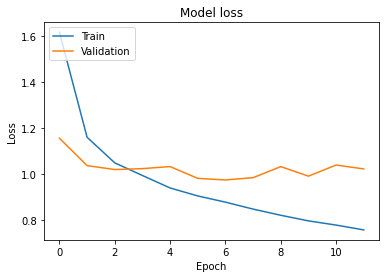

In [25]:
plt.plot(train_hist.history['loss'])
plt.plot(train_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

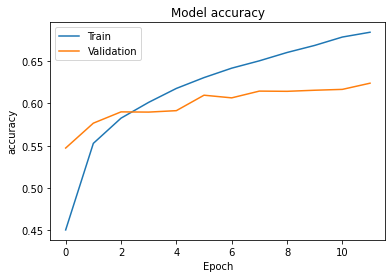

In [26]:
plt.plot(train_hist.history['accuracy'])
plt.plot(train_hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [27]:
model.load_weights(checkpoint_filepath)
test_output = model.predict(test_ds)

In [29]:
results = np.argmax(test_output, 1)
results = list(results)

results = map(lambda x: (x[0]["id"], x[1]), zip(test_ds, results))
results = dict(results)

TypeError: ignored

In [ ]:
with open(PATH_RESULT, 'w') as f:
    f.write('Id,Category\n')

    for key, value in results.items():
        f.write(key + ',' + str(value) + '\n')

In [ ]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt

res = pd.read_csv('result.csv')

sample = res.head()
f = open(PATH_TRAINING)
j = json.load(f)

def get_key(val):
    for key, value in answer_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

for i in range(len(res)):
  image_id = j[str(res.iloc[i,0])]['image_id']
  image_path = PATH_IMAGE + '/'+ str(image_id)+'.png'
  img = plt.imread(image_path)
  plt.imshow(img)
  print(j[str(res.iloc[i,0])]['question'])
  ans = int(res.iloc[i, 1])
  print(get_key(ans))
  plt.show()